In [1]:
# general
import xarray as xr
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib.ticker as plticker
import time
import cmocean
from tqdm.auto import tqdm

import sys
sys.path.append("..")

# custom
from block_update import *
from bouguer import *
from rfgen import *
from prisms import *
from diagnostics import *
from utilities import *

### Load BedMachine

In [2]:
res = 4000
ds = xr.load_dataset(Path(f'processed_data/xr_{res}.nc'))
ds

<xarray.Dataset> Size: 521kB
Dimensions:    (y: 160, x: 125)
Coordinates:
  * x          (x) int32 500B -2098250 -2094250 -2090250 ... -1606250 -1602250
  * y          (y) int32 640B 178250 174250 170250 ... -449750 -453750 -457750
Data variables:
    mapping    |S1 1B b''
    mask       (y, x) int8 20kB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    firn       (y, x) float32 80kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    surface    (y, x) float32 80kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    thickness  (y, x) float32 80kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    bed        (y, x) float32 80kB -650.5 -637.5 -626.7 ... -177.0 -210.0 -206.8
    errbed     (y, x) float32 80kB nan nan nan nan ... 10.0 400.0 400.0 400.0
    source     (y, x) int8 20kB 1 1 1 1 1 1 1 1 1 1 ... 10 10 10 10 10 10 10 6 6
    dataid     (y, x) int8 20kB 0 0 0 0 0 0 0 0 0 0 ... 10 10 10 10 10 10 10 0 0
    geoid      (y, x) int16 40kB -14 -14 -14 -14 -14 -14 ... -29 -29 -29 -29 -29
    inv_msk    (y, x) bool 20kB False False False False ... False False False
Attributes: (12/18)
    Conventions:                 CF-1.7
    Title:                       BedMachine Antarctica
    Author:                      Mathieu Morlighem
    version:                     03-Jun-2022 (v3.4)
    nx:                          13333.0
    ny:                          13333.0
    ...                          ...
    spacing:                     500
    no_data:                     -9999.0
    license:                     No restrictions on access or use
    Data_citation:               Morlighem M. et al., (2019), Deep glacial tr...
    Notes:                       Data processed at the Department of Earth Sy...
    res:                         4000

### Load gravity dataset

In [3]:
grav = pd.read_csv(Path(f'processed_data/grav_leveled_{res}.csv'))

grav.head()

,x,y,faa,height,inv_msk,bouguer,inv_pad
0,-1982250.0,170250.0,-11.000298,4000,False,18.717455,False
1,-1978250.0,170250.0,-11.124400,4000,False,18.207590,False
2,-1958250.0,170250.0,-10.203691,4000,False,17.141898,False
3,-1954250.0,170250.0,-9.980930,4000,False,17.475667,False
4,-1950250.0,170250.0,-9.840794,4000,False,17.914098,False


In [4]:
xx, yy = np.meshgrid(ds.x, ds.y)

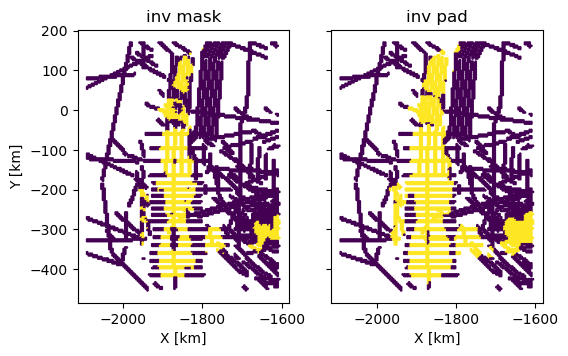

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(6,4), sharey=True)
ax = axs[0]
ax.scatter(grav.x/1000, grav.y/1000, c=grav.inv_msk, s=1)
ax.axis('scaled')
ax.set_title('inv mask')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax = axs[1]
ax.scatter(grav.x/1000, grav.y/1000, c=grav.inv_pad, s=1)
ax.axis('scaled')
ax.set_title('inv pad')
ax.set_xlabel('X [km]')
plt.show()

### Make a target terrain effect using SGS and filter

* The *boug_interpolation_sgs* function makes an SGS realization of the Bouguer disturbance for the given density
* The *filter_boug* function filters the Bouguer disturbance with the given cutoff distance. You can experiment with this parameter to make a target terrain effect that looks like a continuous field. The higher this value, the smoother the Bouguer disturbance will become
* The *sgs_filt* function can be used to do both of these things

In [6]:
target = boug_interpolation_sgs(ds, grav, density=2670)
boug_filt = filter_boug(ds, grav, target, cutoff=12e3, pad=0)
new_target = grav.faa.values - boug_filt

In [7]:
# put gravity into grid for visualization purposes
faa_grid, target_grid, boug_filt_grid = xy_into_grid(
    ds, 
    coords = (grav.x.values, grav.y.values), 
    values = (grav.faa.values, target, boug_filt)
)

In [8]:
boug_sgs = faa_grid - target_grid
new_target_grid = faa_grid - boug_filt_grid

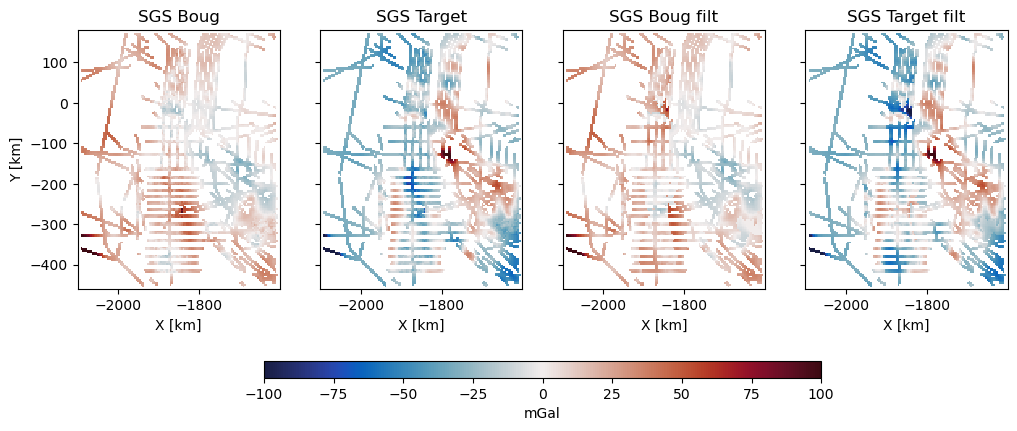

In [9]:
xkm = ds.x/1000
ykm = ds.y/1000

grav_vmin = -100
grav_vmax = 100

fig = plt.figure(figsize=(12,5))

gridspec = GridSpec(2, 4, height_ratios=[1, 0.05])

grids = [boug_sgs, target_grid, boug_filt_grid, new_target_grid]
titles = ['SGS Boug', 'SGS Target', 'SGS Boug filt', 'SGS Target filt']

axs = []
for i, (grid, title) in enumerate(zip(grids, titles)):
    ax = fig.add_subplot(gridspec[0,i])
    axs.append(ax)
    im = ax.pcolormesh(xkm, ykm, grid, vmin=grav_vmin, vmax=grav_vmax, cmap='cmo.balance')
    ax.axis('scaled')
    ax.set_title(title)
    ax.set_xlabel('X [km]')

axs[0].set_ylabel('Y [km]')

for ax in axs[1:]:
    ax.set_yticklabels([])

gs2 = GridSpecFromSubplotSpec(1, 100, gridspec[1,:])
cax = fig.add_subplot(gs2[20:80])
plt.colorbar(im, cax=cax, label='mGal', orientation='horizontal')
plt.show()

### Make a target with *sgs_filt* for inversion and get gravity inside the inv_pad

In [10]:
%%time

target = sgs_filt(ds, grav, 2670, 12e3)
target = target[grav.inv_pad==True]

# trim gravity data
grav_mskd = grav[grav.inv_pad==True]

CPU times: total: 2min 45s
Wall time: 49.9 s


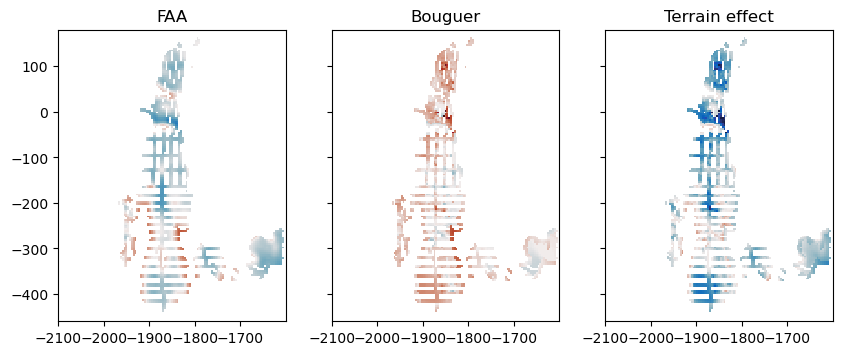

In [11]:
target_invpad, faa_invpad = xy_into_grid(ds, (grav_mskd.x.values, grav_mskd.y.values), (target, grav_mskd.faa.values))

fig, axs = plt.subplots(1, 3, figsize=(10,6), sharey=True)
ax = axs[0]
ax.pcolormesh(ds.x/1000, ds.y/1000, faa_invpad, vmin=-100, vmax=100, cmap='cmo.balance')
ax.axis('scaled')
ax.set_title('FAA')
ax = axs[1]
ax.pcolormesh(ds.x/1000, ds.y/1000, faa_invpad-target_invpad, vmin=-100, vmax=100, cmap='cmo.balance')
ax.axis('scaled')
ax.set_title('Bouguer')
ax = axs[2]
ax.pcolormesh(ds.x/1000, ds.y/1000, target_invpad, vmin=-100, vmax=100, cmap='cmo.balance')
ax.axis('scaled')
ax.set_title('Terrain effect')
plt.show()

### Make random field to change initial condition slightly

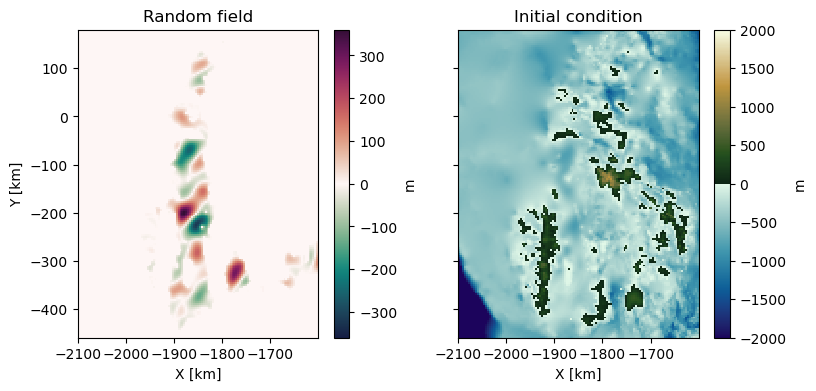

In [12]:
# make arrays for random field generation
range_max = [50e3, 50e3]
range_min = [30e3, 30e3]
high_step = 300
nug_max = 0.0
eps = 3e-4

rfgen = RFGen(ds, range_max, range_min, high_step, nug_max, eps, 'Gaussian', const_var=True)
field = rfgen.generate_field(condition=True)

x0 = ds.bed.values + field
x0 = np.where(x0>ds.surface-ds.thickness, ds.surface-ds.thickness, x0)

vmax = np.max(np.abs(field))

fig, axs = plt.subplots(1, 2, figsize=(9,4), sharey=True)
ax = axs[0]
im = ax.pcolormesh(xkm, ykm, field, vmax=vmax, vmin=-vmax, cmap='cmo.curl')
ax.axis('scaled')
ax.set_title('Random field')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
plt.colorbar(im, ax=ax, label='m')

topo_cm = get_topo_cm()

ax = axs[1]
im = ax.pcolormesh(xkm, ykm, x0, vmax=2000, vmin=-2000, cmap=topo_cm)
ax.axis('scaled')
ax.set_title('Initial condition')
ax.set_xlabel('X [km]')
plt.colorbar(im, ax=ax, label='m')

plt.show()

### Make prism generator and observation coordinates

In [13]:
density_dict = {
    'ice' : 917,
    'water' : 1027,
    'rock' : 2670
}

pred_coords = (grav_mskd.x.values, grav_mskd.y.values, grav_mskd.height.values)

pred_coords[0].shape, target.shape

((2296,), (2296,))

### Set parameters for inversion and run the inversion

* You will want to tune the block parameter sequence to make the inversion
* The sigma gravity uncertainty comes from crossover errors in my data. You can use this or change it if you have information about the uncertainty of your gravity data. This will change how likely the MCMC is to accept changes that make the error worse.
* The stopping criterion stops the inversion once the RMSE reaches a certain point. You will want to experiment to find a value that your inversion can reach in a reasonable amount of time. Note that you don't really want to push this to find the lowest value that you can reach. The inversion will overfit the data as it continues.

In [14]:
# block size, range, amplitude, iterations
sequence = [
    [21, 10, 60, 1000],
    [15, 8, 40, 1000],
    [9, 6, 40, 5000],
    [5, 5, 40, 20000]
]

# gravity uncertainty
sigma = 1.6

# RMSE stopping condition
stop = 1.2

# get random number generator
rng = np.random.default_rng(seed=0)

# run chain sequence and time it
tic = time.time()
result = chain_sequence(sequence, ds, x0, pred_coords, target, sigma, density_dict, rng, stop=stop)
toc = time.time()
print(f'total time: {toc-tic:.1f}')

  0%|          | 0/1000 [00:00<?, ?it/s]

chain 0 efficiency: -0.243 RMSE/sec


  0%|          | 0/1000 [00:00<?, ?it/s]

chain 1 efficiency: -0.060 RMSE/sec


  0%|          | 0/5000 [00:00<?, ?it/s]

chain 2 efficiency: -0.026 RMSE/sec


  0%|          | 0/20000 [00:00<?, ?it/s]

chain 3 efficiency: -0.004 RMSE/sec
0 finished
total time: 453.1


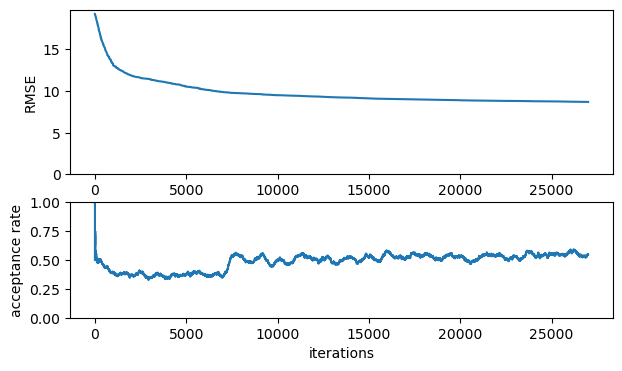

In [15]:
rmse = np.sqrt(result['loss_cache']/target.size)

fig, axs = plt.subplots(2, 1, figsize=(7,4), gridspec_kw=dict(height_ratios=[1,0.7]))
ax = axs[0]
ax.plot(rmse)
ax.set_ylim(0, np.max(rmse)+0.5)
ax.set_ylabel('RMSE')

# running acceptance rate with a 500 iteration window
run_acc = run_acceptance_rate(result['step_cache'], 500, 0)

ax = axs[1]
ax.plot(run_acc)
ax.set_xlabel('iterations')
ax.set_ylabel('acceptance rate')
ax.set_ylim(0, 1)
plt.show()

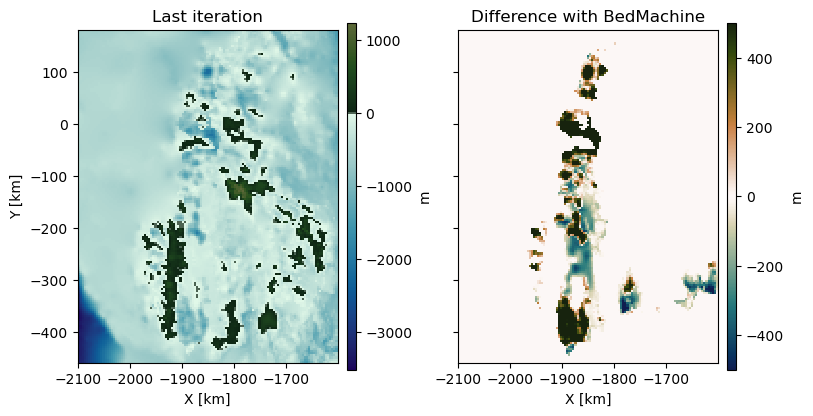

In [16]:
bed = result['bed_cache']

topo_cmap = get_topo_cm()
topo_crop = cmocean.tools.crop(topo_cmap, np.min(bed), np.max(bed), 0)
vmin_topo = np.min(bed); vmax_topo = np.max(bed)

fig, axs = plt.subplots(1, 2, figsize=(9,4.5), sharey=True)

# plot last bed iteration
ax = axs[0]
im = ax.pcolormesh(xkm, ykm, bed, vmin=vmin_topo, vmax=vmax_topo, cmap=topo_crop)
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.set_title('Last iteration')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='m')

# plot difference from BedMachine
ax = axs[1]
im = ax.pcolormesh(xkm, ykm, ds.bed-bed, vmin=-500, vmax=500, cmap='cmo.tarn_r')
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_title('Difference with BedMachine')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='m')
plt.show()

### Let's look at the gravity residual at the end

In [17]:
target_grid, grav_result_grid = xy_into_grid(ds, (pred_coords[0], pred_coords[1]), 
                                             (target, result['grav_cache']))

residual_grid = target_grid - grav_result_grid

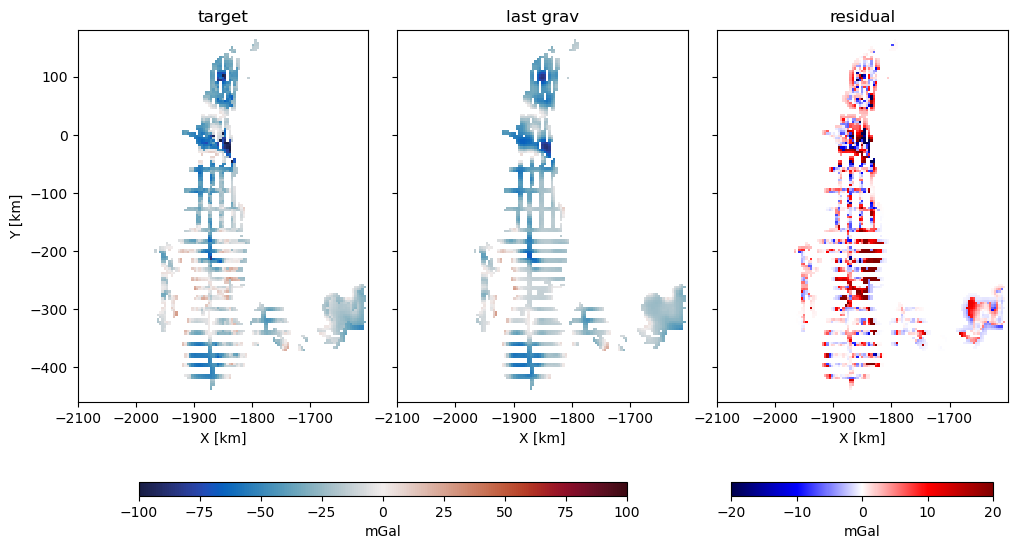

In [18]:
#fig, axs = plt.subplots(1, 3, figsize=(15,5), sharey=True)

fig = plt.figure(figsize=(12,6.5))
gridspec = GridSpec(2, 3, height_ratios=[1, 0.03], wspace=0.1)

ax1 = fig.add_subplot(gridspec[0,0])
ax2 = fig.add_subplot(gridspec[0,1])
ax3 = fig.add_subplot(gridspec[0,2])

ax = ax1
im = ax.pcolormesh(xkm, ykm, target_grid, vmin=-100, vmax=100, cmap='cmo.balance')
ax.axis('scaled')
ax.set_title('target')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')

ax = ax2
im = ax.pcolormesh(xkm, ykm, grav_result_grid, vmin=-100, vmax=100, cmap='cmo.balance')
ax.axis('scaled')
ax.set_title('last grav')
ax.set_xlabel('X [km]')
ax.set_yticklabels([])

gs2 = GridSpecFromSubplotSpec(1, 100, gridspec[1,:2])
cax = fig.add_subplot(gs2[10:90])
plt.colorbar(im, cax=cax, label='mGal', orientation='horizontal')

ax = ax3
im = ax.pcolormesh(xkm, ykm, residual_grid, vmin=-20, vmax=20, cmap='seismic')
ax.axis('scaled')
ax.set_title('residual')
ax.set_xlabel('X [km]')
ax.set_yticklabels([])

gs3 = GridSpecFromSubplotSpec(1, 100, gridspec[1,2])
cax = fig.add_subplot(gs3[5:95])
plt.colorbar(im, cax=cax, label='mGal', orientation='horizontal')
plt.show()

### Filter the final bed iteration

The inversion process can create some edge artifacts because of the blocks. Let's use a lowpass Gaussian filter to smooth it out a little. You can change the cutoff to change how much smoothing there is.

In [19]:
bed_filt = lowpass_filter_invpad(ds, bed, cutoff=5e3)
bed_filt = bed_filt.reshape(bed.shape)
bed_high = bed-bed_filt

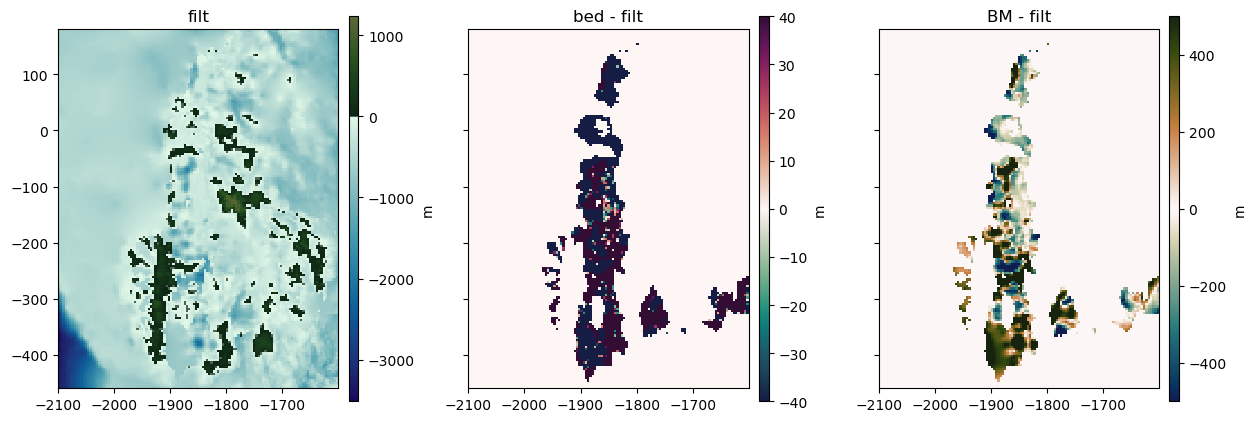

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(15,5), sharey=True)
ax = axs[0]
im = ax.pcolormesh(xkm, ykm, bed_filt, vmin=vmin_topo, vmax=vmax_topo, cmap=topo_crop)
ax.axis('scaled')
ax.set_title('filt')
plt.colorbar(im, pad=0.03, aspect=40, ax=ax, label='m')

ax = axs[1]
im = ax.pcolormesh(xkm, ykm, bed-bed_filt, vmin=-40, vmax=40, cmap='cmo.curl')
ax.axis('scaled')
ax.set_title('bed - filt')
plt.colorbar(im, pad=0.03, aspect=40, ax=ax, label='m')

ax = axs[2]
im = ax.pcolormesh(xkm, ykm, ds.bed-bed_filt, vmin=-500, vmax=500, cmap='cmo.tarn_r')
ax.axis('scaled')
ax.set_title('BM - filt')
plt.colorbar(im, pad=0.03, aspect=40, ax=ax, label='m')
plt.show()

### We can look at the high frequency and see that it has linear edges in it

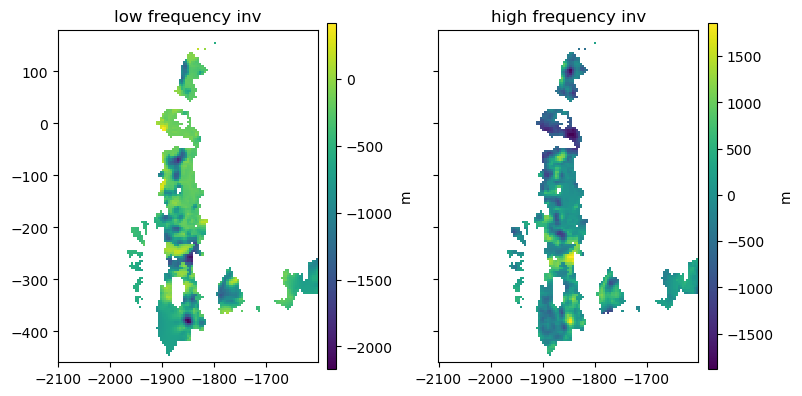

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(9,4.5), sharey=True)

ax = axs[0]
im = ax.pcolormesh(xkm, ykm, np.where(ds.inv_msk, bed_filt, np.nan))
ax.axis('scaled')
ax.set_title('low frequency inv')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='m')

ax = axs[1]
im = ax.pcolormesh(xkm, ykm, np.where(ds.inv_msk, bed_high, np.nan))
ax.axis('scaled')
ax.set_title('high frequency inv')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='m')
plt.show()

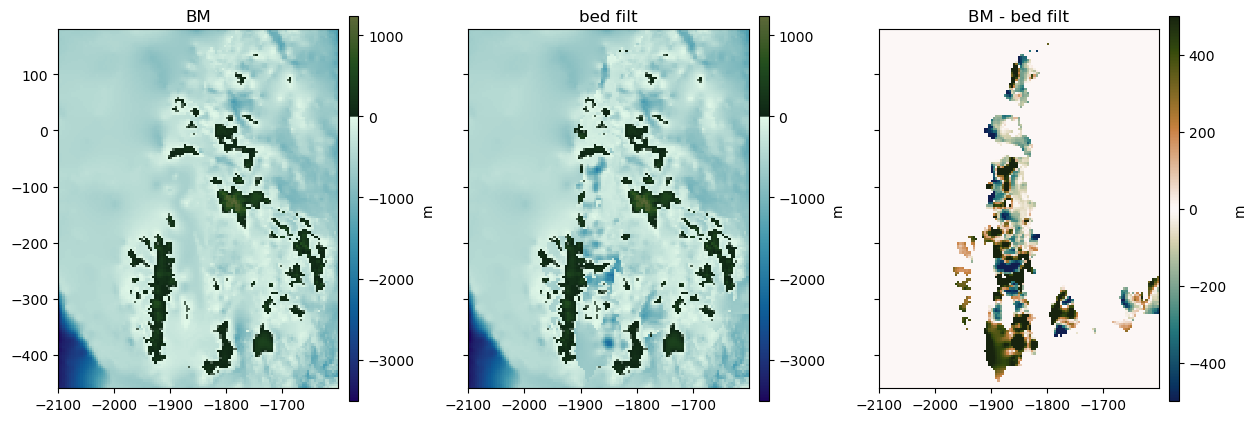

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(15,5), sharey=True)
ax = axs[0]
im = ax.pcolormesh(xkm, ykm, ds.bed, vmin=vmin_topo, vmax=vmax_topo, cmap=topo_crop)
ax.axis('scaled')
ax.set_title('BM')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='m')

ax = axs[1]
im = ax.pcolormesh(xkm, ykm, bed_filt, vmin=vmin_topo, vmax=vmax_topo, cmap=topo_crop)
ax.axis('scaled')
ax.set_title('bed filt')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='m')

ax = axs[2]
im = ax.pcolormesh(xkm, ykm, ds.bed-bed_filt, vmin=-500, vmax=500, cmap='cmo.tarn_r')
ax.axis('scaled')
ax.set_title('BM - bed filt')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='m')
plt.show()

## Conditioning on boundary of inversion domain

* These are weights that will be applied to updates to prevent dramatic changes on the inversion domain boundary.
* These functions can be used to make weights using a logistic function
* You can test out different parameters to the logistic function to make different weights
* Having low weights near the conditioning data will make it take longer to lower the RMSE

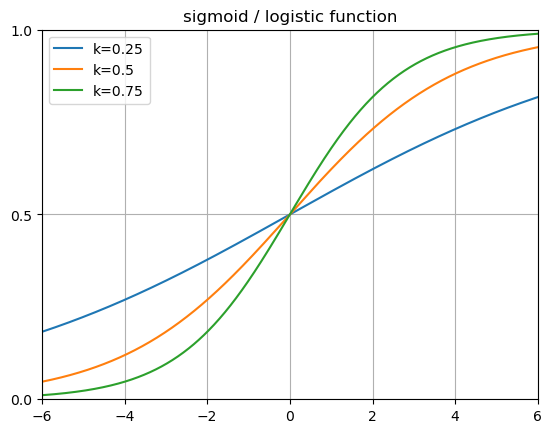

In [24]:
tmp = np.linspace(-6, 6, 1000)

fig, ax = plt.subplots()

for k in [0.25, 0.5, 0.75]:
    ax.plot(tmp, logistic(tmp, 1, 0, k), label=f'k={str(k)}')
    
intervals = 0.5
loc = plticker.MultipleLocator(base=intervals)
ax.yaxis.set_major_locator(loc)
intervals = 2
loc = plticker.MultipleLocator(base=intervals)
ax.xaxis.set_major_locator(loc)
ax.grid(which='major', axis='both', linestyle='-')
ax.set_ylim(0, 1.0)
ax.set_xlim(-6, 6)
ax.set_title('sigmoid / logistic function')
ax.legend()
plt.show()

### Test out parameters to apply to the rescaled distance from conditioning data

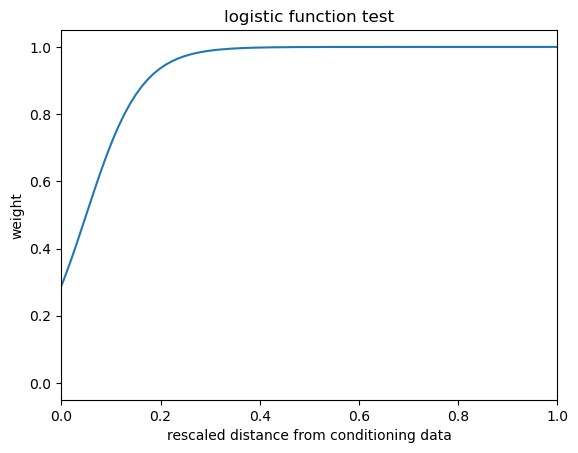

In [25]:
plt.plot(tmp, logistic(tmp, 1, 0.05, 18))
plt.xlim(0, 1)
plt.xlabel('rescaled distance from conditioning data')
plt.ylabel('weight')
plt.title('logistic function test')
plt.show()

In [26]:
xx, yy = np.meshgrid(ds.x, ds.y)
min_dist_l2 = min_dist_simple(~ds.inv_msk.values, xx, yy)

dist_scale = rescale(min_dist_l2)
dist_logi = logistic(dist_scale, 1, 0.05, 18)
dist_logi = np.where(ds.inv_msk==False, 0, dist_logi)

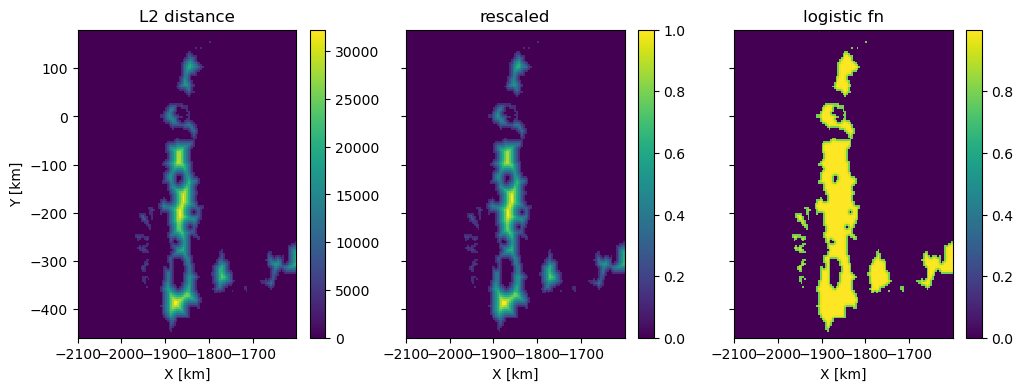

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(12,4), sharey=True)
ax = axs[0]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, min_dist_l2)
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.set_title('L2 distance')
plt.colorbar(im, ax=ax)

ax = axs[1]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, dist_scale)
ax.set_xlabel('X [km]')
ax.set_title('rescaled')
plt.colorbar(im, ax=ax)

ax = axs[2]
im = ax.pcolormesh(ds.x/1000, ds.y/1000, dist_logi)
ax.set_xlabel('X [km]')
ax.set_title('logistic fn')
plt.colorbar(im, ax=ax)

plt.show()

### Run inversion with conditioning weights

In [28]:
x0 = ds.bed.data + field
x0 = np.where(x0>ds.surface-ds.thickness, ds.surface-ds.thickness, x0)

rng = np.random.default_rng(seed=0)

stop = 1.2

tic = time.time()
result = chain_sequence(sequence, ds, x0, pred_coords, target, sigma, density_dict, rng, dist_logi, stop=stop)
toc = time.time()
print(f'total time: {toc-tic:.1f}')

  0%|          | 0/1000 [00:00<?, ?it/s]

chain 0 efficiency: -0.239 RMSE/sec


  0%|          | 0/1000 [00:00<?, ?it/s]

chain 1 efficiency: -0.057 RMSE/sec


  0%|          | 0/5000 [00:00<?, ?it/s]

chain 2 efficiency: -0.037 RMSE/sec


  0%|          | 0/20000 [00:00<?, ?it/s]

chain 3 efficiency: -0.010 RMSE/sec
0 finished
total time: 249.6


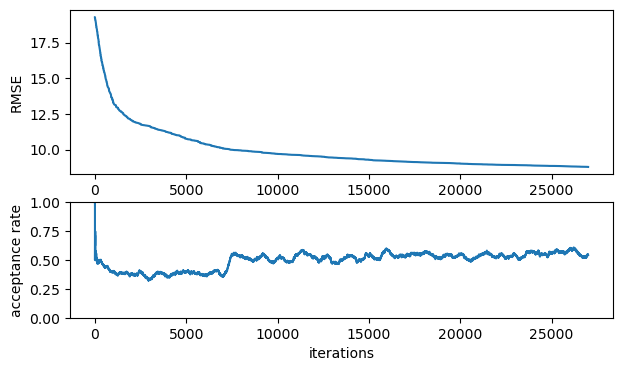

In [29]:
rmse = np.sqrt(result['loss_cache']/target.size)

fig, axs = plt.subplots(2, 1, figsize=(7,4), gridspec_kw=dict(height_ratios=[1,0.7]))
ax = axs[0]
ax.plot(rmse)
ax.set_ylabel('RMSE')

# running acceptance rate with a 500 iteration window
run_acc = run_acceptance_rate(result['step_cache'], 500, 0)

ax = axs[1]
ax.plot(run_acc)
ax.set_xlabel('iterations')
ax.set_ylabel('acceptance rate')
ax.set_ylim(0, 1)
plt.show()

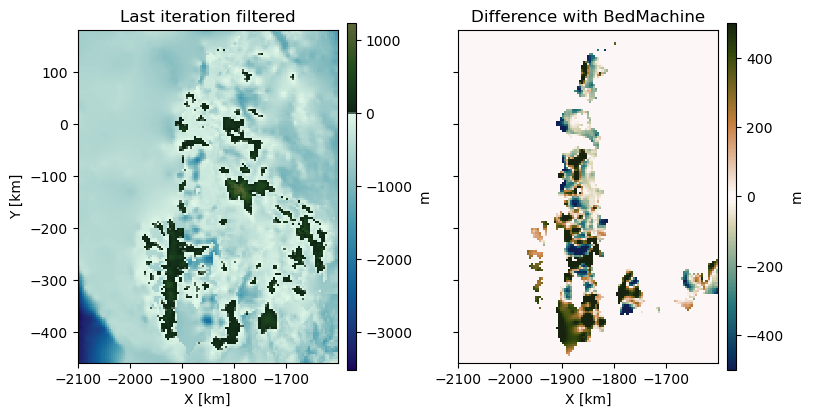

In [30]:
bed = result['bed_cache']

bed_filt = lowpass_filter_invpad(ds, bed, cutoff=5e3)
bed_filt = bed_filt.reshape(bed.shape)

topo_cmap = get_topo_cm()
topo_crop = cmocean.tools.crop(topo_cmap, np.min(bed), np.max(bed), 0)
vmin_topo = np.min(bed); vmax_topo = np.max(bed)

fig, axs = plt.subplots(1, 2, figsize=(9,4.5), sharey=True)

# plot last bed iteration
ax = axs[0]
im = ax.pcolormesh(xkm, ykm, bed_filt, vmin=vmin_topo, vmax=vmax_topo, cmap=topo_crop)
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.set_title('Last iteration filtered')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='m')

# plot difference from BedMachine
ax = axs[1]
im = ax.pcolormesh(xkm, ykm, ds.bed-bed_filt, vmin=-500, vmax=500, cmap='cmo.tarn_r')
ax.axis('scaled')
ax.set_xlabel('X [km]')
ax.set_title('Difference with BedMachine')
plt.colorbar(im, ax=ax, pad=0.03, aspect=40, label='m')
plt.show()